In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Cài đặt giá trị ngẫu nhiên cố định:

In [91]:
random_state = 59
np.random.seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

### Cài đặt thiết bị tính toán:

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Đọc bộ dữ liệu:

In [93]:
data_path = "NonLinear_data.npy"
data = np.load(data_path, allow_pickle=True).item()

### Tiền xử lý bộ dữ liệu:

#### (a) Tách đặc trưng X và nhãn y:

In [94]:
print(data.keys())
X = data['X']
y = data['labels']

dict_keys(['X', 'labels'])


In [95]:
X[:5]

array([[0.        , 0.        ],
       [0.00096008, 0.01005528],
       [0.01045864, 0.01728405],
       [0.00087922, 0.03029027],
       [0.00991727, 0.03916803]])

In [96]:
y[:5]

array([0, 0, 0, 0, 0], dtype=uint8)

#### (b) Chia bộ dữ liệu train/val/test: 7:2:1

In [97]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle)

#### (c) Chuẩn hóa đặc trưng đầu vào:

In [98]:
normalize = StandardScaler()

X_train = normalize.fit_transform(X_train)
X_val = normalize.transform(X_val)
X_test = normalize.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

### Xây dựng DataLoader:

Document use DataLoader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [99]:
class CustomDataset:
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, key):
        return (self.X[key], self.y[key])

In [100]:
batch_size = 32

# Tạo dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Xây dựng mạng MLP:

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        output = self.output(x)
        # Loại bỏ chiều dư thừa (chiều nào bằng 1 thì bỏ)
        return output.squeeze(1)

In [102]:
input_dims = X.shape[1]
output_dims = len(np.unique(y))
hidden_dims = 512
model = MLP(input_dims, hidden_dims, output_dims).to(device=device)

### Khai báo hàm loss và optimizer:

In [103]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [104]:
total = 0
for params in model.parameters():
    total += params.numel()

total

3075

### Xây dựng hàm tính độ chính xác:

In [ ]:
def compute_accuracy(y_hat, y_true):
    y_hat = np.argmax(y_hat,axis=1)
    y_true = np.array(y_true)
    N = len(y_true)
    correct = np.sum((y_hat == y_true))
    return  correct / N

### Huấn luyện mô hình:

In [106]:
epochs = 100
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for x_b_train, y_b_train in train_loader:
        x_b_train = x_b_train.to(device)
        y_b_train = y_b_train.to(device)

        optimizer.zero_grad()
        y_b_predict = model(x_b_train)
        loss = criterion(y_b_predict, y_b_train)
        loss.backward()
        optimizer.step()

        train_predict.extend(y_b_predict.tolist())
        train_target.extend(y_b_train.tolist())

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # kh cần xài softmax ở target vì y tỷ lệ thuận với y_softmax nên giá trị y lớn thì khi chuyển qua y_softmax cx lớn
    train_accuracy.append(compute_accuracy(
        y_true=train_target, y_hat=train_predict))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_b_val, y_b_val in val_loader:
            x_b_val = x_b_val.to(device)
            y_b_val = y_b_val.to(device)

            y_val_predict = model(x_b_val)
            loss = criterion(y_val_predict, y_b_val)
            val_loss += loss.item()

            val_predict.extend(y_val_predict.tolist())
            val_target.extend(y_b_val.tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy.append(compute_accuracy(y_true=val_target, y_hat=val_predict))

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.931	Validation loss: 1.064

EPOCH 2:	Training loss: 0.836	Validation loss: 1.069

EPOCH 3:	Training loss: 0.748	Validation loss: 0.958

EPOCH 4:	Training loss: 0.787	Validation loss: 0.981

EPOCH 5:	Training loss: 0.723	Validation loss: 0.862

EPOCH 6:	Training loss: 1.130	Validation loss: 1.077

EPOCH 7:	Training loss: 0.764	Validation loss: 0.765

EPOCH 8:	Training loss: 0.737	Validation loss: 0.848

EPOCH 9:	Training loss: 0.709	Validation loss: 0.797

EPOCH 10:	Training loss: 0.784	Validation loss: 0.736

EPOCH 11:	Training loss: 0.797	Validation loss: 0.789

EPOCH 12:	Training loss: 0.635	Validation loss: 0.766

EPOCH 13:	Training loss: 0.776	Validation loss: 0.810

EPOCH 14:	Training loss: 0.643	Validation loss: 0.676

EPOCH 15:	Training loss: 0.704	Validation loss: 0.955

EPOCH 16:	Training loss: 0.619	Validation loss: 0.723

EPOCH 17:	Training loss: 0.636	Validation loss: 0.644

EPOCH 18:	Training loss: 0.566	Validation loss: 0.696

EPOCH 19:	Training

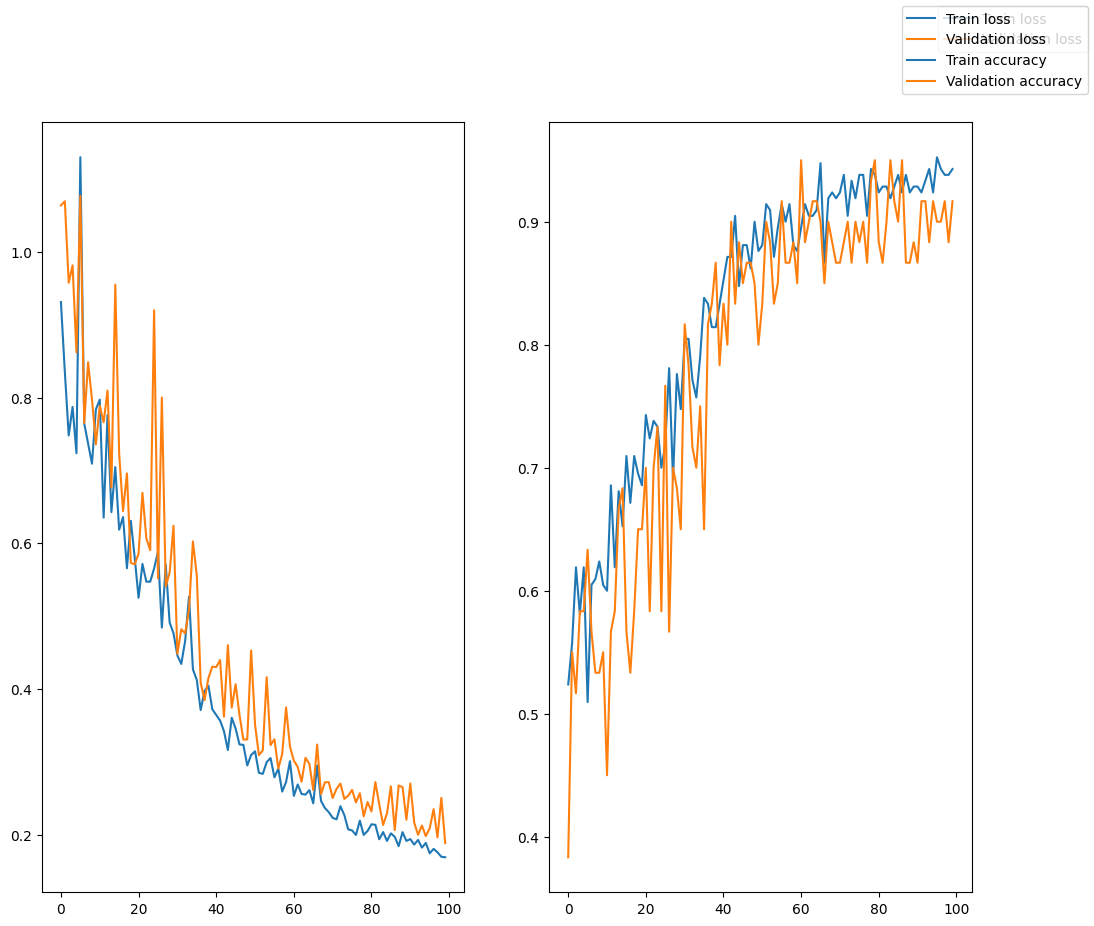

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].plot(np.arange(epochs), train_losses, label = 'Train loss')
ax[0].plot(np.arange(epochs), val_losses, label='Validation loss')
fig.legend()

ax[1].plot(np.arange(epochs), train_accuracy, label='Train accuracy')
ax[1].plot(np.arange(epochs), val_accuracy, label='Validation accuracy')
fig.legend()

In [108]:
test_accuracy = []  
test_loss = 0.0  
model.eval()  
with torch.no_grad():  
    for x_b_test, y_b_test in test_loader:  
        x_b_test = x_b_test.to(device)
        y_b_test = y_b_test.to(device)  

        y_test_predict = model(x_b_test)

        loss = criterion(y_test_predict, y_b_test)
        test_loss += loss.item()

        test_accuracy.append(compute_accuracy(
            y_true=y_b_test.tolist(), y_hat=y_test_predict.tolist()))

test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.2289
Test Accuracy: [0.8333333333333334]
